In [1]:
#%% import
import os
from glob import glob
import re
import ast
import numpy as np 
import pandas as pd
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
import numpy as np 
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dense, Dropout, Flatten
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import cv2

In [3]:
#%% set label dictionary and params
classfiles = os.listdir('../Data/5_animals/')
numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)} #adds underscores

num_classes = 5    #340 max 
imheight, imwidth = 32, 32  
ims_per_class = 10000  #max?

In [4]:
# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

#%% get train arrays
train_grand = []
class_paths = glob('../Data/5_animals/*.csv')
for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=ims_per_class*5//4)
    train = train[train.recognized == True].head(ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())  # PARALLELIZE
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

100%|██████████| 5/5 [00:25<00:00,  5.02s/it]


In [5]:
# memory-friendly alternative to train_test_split?
valfrac = 0.3
cutpt = int(valfrac * train_grand.shape[0])

np.random.shuffle(train_grand)
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:] #validation set is recognized==True

#del train_grand

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_valid = keras.utils.to_categorical(y_val, num_classes)
X_valid = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

y_val = y_valid[:len(y_valid)//2]
X_val = X_valid[:len(X_valid)//2]

y_test = y_valid[len(y_valid)//2:]
X_test = X_valid[len(X_valid)//2:]

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape, "\n",
      y_test.shape, "\n",
      X_test.shape)

(35000, 5) 
 (35000, 32, 32, 1) 
 (7500, 5) 
 (7500, 32, 32, 1) 
 (7500, 5) 
 (7500, 32, 32, 1)


In [6]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

inputs = keras.Input(shape=(32,32,1))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=16, kernel_size=3, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

x = layers.Flatten()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                         

In [7]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="models/1_CNN_Model_From_Scratch2.h5", save_best_only=True, monitor="val_loss")]

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train,
          batch_size = 128,
          epochs = 250,
          validation_data = (X_val, y_val),
          callbacks = callbacks)

Epoch 1/250
274/274 [==============================] - 7s 14ms/step - loss: 1.5243 - accuracy: 0.3143 - val_loss: 2.0373 - val_accuracy: 0.2336
Epoch 2/250
274/274 [==============================] - 3s 11ms/step - loss: 1.3777 - accuracy: 0.4195 - val_loss: 2.3698 - val_accuracy: 0.2433
Epoch 3/250
274/274 [==============================] - 3s 11ms/step - loss: 1.2757 - accuracy: 0.4686 - val_loss: 1.9460 - val_accuracy: 0.3185
Epoch 4/250
274/274 [==============================] - 3s 11ms/step - loss: 1.2083 - accuracy: 0.5037 - val_loss: 1.5286 - val_accuracy: 0.4296
Epoch 5/250
274/274 [==============================] - 3s 11ms/step - loss: 1.1588 - accuracy: 0.5241 - val_loss: 1.7155 - val_accuracy: 0.4044
Epoch 6/250
274/274 [==============================] - 3s 11ms/step - loss: 1.1050 - accuracy: 0.5517 - val_loss: 1.5569 - val_accuracy: 0.4600
Epoch 7/250
274/274 [==============================] - 3s 11ms/step - loss: 1.0570 - accuracy: 0.5716 - val_loss: 1.0284 - val_accuracy:

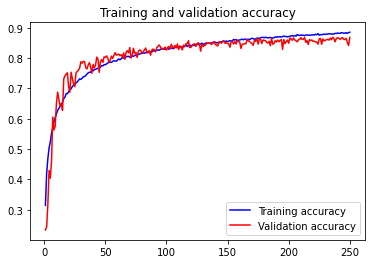

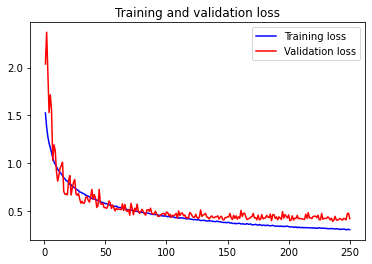

In [8]:
def plot_function(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

plot_function(history)

In [9]:
test_model = keras.models.load_model("models/1_CNN_Model_From_Scratch2.h5")
test_loss, test_acc = test_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

235/235 [==============================] - 1s 4ms/step - loss: 0.4036 - accuracy: 0.8664
Test accuracy: 0.866


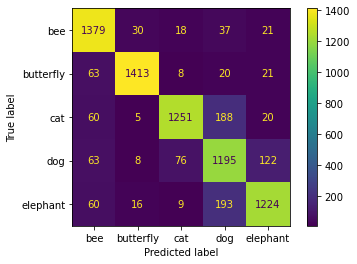

In [11]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = test_model.predict(X_test) 
y_pred = (predictions >= 0.5)
rounded_labels=np.argmax(y_test, axis=1)

matrix = metrics.confusion_matrix(rounded_labels, y_pred.argmax(axis=1))
matrix.diagonal()/matrix.sum(axis=1)
cmd = ConfusionMatrixDisplay(matrix, display_labels=['bee','butterfly','cat','dog','elephant'])
cmd.plot()